##  <center> REDES RECURRENTES SOBRE TEXTO  <br><img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/MARCA-Color.jpg" title="Title text" width="20%" height="15%" /><br>Andrea Carolina Reales Villalba -- Jesus Eduardo Ortiz Sandoval <BR>Punto 1 </center>

Hoy en dı́a, una aplicación relevante de las redes neuronales recurrentes es el modelamiento de texto y lenguaje natural. En esta sección abordaremos el problema de procesar sentencias de texto, proporcionadas por GMB (*Groningen Meaning Bank*), para reconocimiento de entidades y tagger. En específico, trabajaremos con el dataset proprocionado a través de __[Kaggle](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus)__, que está compuesto por más de un millón de palabras, a fin de realizar predicciones sobre distintas tareas del tipo *many to many* y *many to one*.

<img src="https://i.stack.imgur.com/b4sus.jpg" width="70%" />


Descargue los datos de la página de Kaggle y cárguelos mediante *pandas*.

In [0]:
import pandas as pd
import numpy as np
import re, os, sys
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [36]:
df_ner=pd.read_csv('gdrive/My Drive/Colab Notebooks/ner.csv', encoding ="cp1252", error_bad_lines=False)
df_ner.dropna(inplace=True)

b'Skipping line 281837: expected 25 fields, saw 34\n'


In [0]:
df_ner.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1050794 entries, 0 to 1050794
Data columns (total 25 columns):
Unnamed: 0         1050794 non-null int64
lemma              1050794 non-null object
next-lemma         1050794 non-null object
next-next-lemma    1050794 non-null object
next-next-pos      1050794 non-null object
next-next-shape    1050794 non-null object
next-next-word     1050794 non-null object
next-pos           1050794 non-null object
next-shape         1050794 non-null object
next-word          1050794 non-null object
pos                1050794 non-null object
prev-iob           1050794 non-null object
prev-lemma         1050794 non-null object
prev-pos           1050794 non-null object
prev-prev-iob      1050794 non-null object
prev-prev-lemma    1050794 non-null object
prev-prev-pos      1050794 non-null object
prev-prev-shape    1050794 non-null object
prev-prev-word     1050794 non-null object
prev-shape         1050794 non-null object
prev-word          1050794 n

En este caso tenemos un dataset con un peso de 125 MB, hemos subido este archivo a nuestro Drive para poder hacer la conexión con el colaboratory y cargarlo directamente, se tiene que colocar las palabras de configuracion en la lectura del csv ya que encontramos campos vacios o que no serian reconocidos por la función de carga del programa.

Antes de comenzar la explicación de la tarea, basado en la sustentación que tuvimos el dia 21 de agosto, encontramos que teniamos algunas diferencias con los resultados de los compañeros, aunque hubieramos querido tener un poco mas de tiempo para poder hacer implementaciones de todo lo visto y comparar con lo que tenemos nosotros por motivos de fuerza mayor no logramos hacerlo. 

Vamos a dejar la construcción con el mismo número de labels, intentamos tomar diferentes filas pero siempre obtuvimos 41 labels, no sabemos en que estamos fallando pero si vemos el resultado podemos afirmar que tambin hay algo que esta trabajando bien, por que la metrica es buena y cuando hicimos la ultima parte de componer texto logramos tener resultados, tal vez se debe a nuestra falta de experiencia en esta disciplina o un error que seria logicamente infimo, un cambio que a nuestro parecer es interesante es que en pruebas que teniamos con 17 labels el resultado del padding utilizando pre es muy inferior comparado con post, en este momento hicimos simulaciones nuevamente y comparando y encontramos que Pre es mejor que post pero no por mucho, solo aproximadamente 3 puntos de score, vamos a dejar algunas pruebas con Pre y otras con Post para poder discutir los resultados y ver si al final con la sintonización de los parametros esta diferencia se mantiene, aumenta o disminuye.

La otra observación que nos hicieron y que si queremos hacer cambios es en la metrica de evaluacion de los modelos, nosotros unicamente estabamos trabajando con Micro, honestamente no habiamos comprendido muy bien como funcionaba esta metrica, y nos hicieron observaciónes que esta metrica no era muy adecuada para trabajarla con este tipo de problema por la distribución que tienen las etiquetas y que no estan distribuidas de una manera constante, hicimos pruebas con las otras  metricas que se comentan que efectivamente pueden trabajar  con las caracteristicas de este set de datos.

a) En esta primera instancia trabajaremos con la tarea de realizar un NER *tag* (**Named Entity Recognition**) sobre cada una de las palabras en las sentencias que se nos presenta en los datos. Esta tarea es del tipo *many to many*, es decir, la entrada es una secuencia y la salida es una secuencia, sin *shift*, por lo que necesitaremos una estructura de red adecuada a ésto. En primer lugar extraiga las columnas que utilizaremos del dataset **¿Por qué es conveniente utilizar *lemma* en vez de la palabra misma *word*?**

In [4]:
dataset = df_ner.loc[:,["lemma","word","pos","tag","prev-iob"]]
dataset.head()

,lemma,word,pos,tag,prev-iob
0,thousand,Thousands,NNS,O,__START1__
1,of,of,IN,O,O
2,demonstr,demonstrators,NNS,O,O
3,have,have,VBP,O,O
4,march,marched,VBN,O,O


In [37]:
dataset = df_ner.loc[:,["lemma","pos","tag","prev-iob"]]
dataset.head()

,lemma,pos,tag,prev-iob
0,thousand,NNS,O,__START1__
1,of,IN,O,O
2,demonstr,NNS,O,O
3,have,VBP,O,O
4,march,VBN,O,O


Lo que sucede es que en NLP es necesario hacer un prepreocesamiento de los textos para poder agruparlos y que trabajen de manera correcta, el lemma es una forma de procesamiento de las palabras que hace el analisis morfologico de las palabras y busca su forma mas general pero que siga conteniendo el significado, entonces utilizamos esa columna y nos ahorramos un paso de procesamiento de texto.  En este caso cargamos de dos formas distintar el set de datos, lo realizamos de esta forma por que en un momento nos genero demasiado problemas quedando fuera de memoria o muriendo el kernel.


---



Luego de esto cree una estructura que contendrá todas las sentencias u oraciones y otra estructura que contendrá los las etiquetas (tags), esto es un arreglo de arreglos de lemmas y un arreglo de arreglos de tags respectivamente. **¿Cuales son las dimensiones de ambas estructuras? ¿Cada dato de ejemplo tiene las mismas dimensiones que el resto?**

In [0]:
sentence = []
labels_sentence = []
dataX,dataY = [],[]
#uniques
lemmas,labels = set(), set()

for fila in dataset.values:
    if fila[-1]=="__START1__": 
        dataX.append(np.asarray(sentence))
        dataY.append(np.asarray(labels_sentence))
        sentence = []
        labels_sentence = []
    lemmas.add(fila[0])
    labels.add(fila[1])
    sentence.append(fila[0])#add lemma
    labels_sentence.append(fila[1]) #POS o TAG
#data to  array
dataX = np.asarray(dataX[1:])
dataY = np.asarray(dataY[1:])

En esta sección de codigo es donde creemos esta el error o algun procedimiento mal, ya que muchos compañeros extrajeron 17 labels y nosotros 41, en un primer instante nosotros habiamos extraido 17, pero teniamos problemas de Memory error, y solo lograbamos utilizar los primeros 200.000 valores referentes a todo el set de entrenamiento, cuando eliminamos la columna words, que en realidad no tiene ningun impacto real sobre todo el ejercicio pasamos a extraer 41 caracteristicas sin el problema de memoria, despues de la exposición volvimos  a hacer la prueba e inmediatamente teniamos un error de kernel, y se cerraba el colaboratory, vamos a seguir manejando con los Tags, y evaluaremos los resultados obtenidos para poder comprender si efectivamente hay alguna diferencia al trabajar solo con esta herramienta.

In [39]:
print("Cantidad labels: ", len(labels))
print("Cantidad lemmas: ", len(lemmas))
print("Tamaño matriz de lemmas: ", dataX.shape)
print("Tamaño matriz de labels: ", dataY.shape)

Cantidad labels:  41
Cantidad lemmas:  20243
Tamaño matriz de lemmas:  (48081,)
Tamaño matriz de labels:  (48081,)


In [0]:
from keras.preprocessing import sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout
from sklearn.metrics import f1_score
from keras.layers import Bidirectional
import random,sys
from keras.callbacks import LambdaCallback
from keras.layers import Dropout

Mantenemos la carga de las librerias despues del pre-procesamiento para no sobrecargar el laboratory evitar la perida de información por cierres inesperados del programa.

b) Estudie la distribución del largo de los textos a procesar. Estudie también la frecuencia con la que aparecen las palabras en todo el dataset. **¿Se observa una ley Zipf?**[[1]](#refs) Realice un gráfico de la cantidad de datos por clase. Comente.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


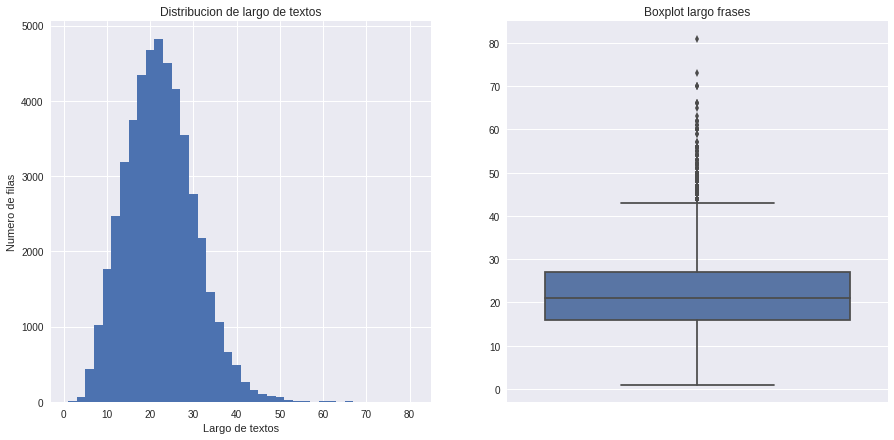

In [41]:
phrases_len = []
for row in dataX:
    phrases_len.append(len(row))

plt.figure(figsize=(15,7))
plt.subplot(121)
plt.hist(phrases_len, bins=40)
plt.xlabel("Largo de textos")
plt.ylabel("Numero de filas")
plt.title("Distribucion de largo de textos")
plt.subplot(122)
sns.boxplot(phrases_len, labels=["Matriz frases"],orient='v')
plt.title("Boxplot largo frases")
plt.show()

Aca hacemos el analisis del largo de textos en la figura de la derecha contra el numero filas, observamos que hay una distribución mayor orientada a un largo de textos aproximado en el intervalo de 20-30, en el largo de las grases observamos que la gran mayoria de los datos s eubican hasta 28 palabras, esta es una herramienta para posteriormente hacer la elección de padding adecuada.

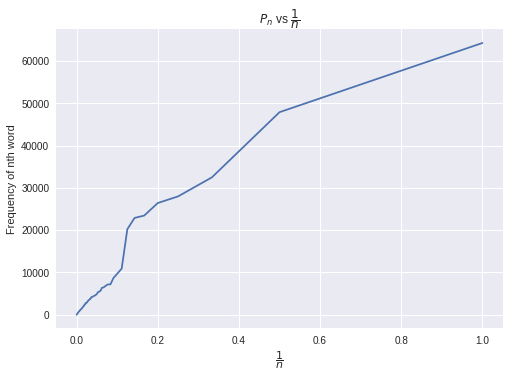

In [84]:
phrases_len = []
word_count = dict()
for row in dataX:
    phrases_len.append(len(row))
    for word in row:
        if word not in word_count:
            word_count[word] = 0
        word_count[word] += 1

freq = sorted(list(word_count.values()), reverse = True)
oneOverN = 1/np.arange(1, len(freq)+1)
plt.plot(oneOverN, freq)
plt.xlabel("$\\dfrac{1}{n}$")
plt.ylabel("Frequency of nth word")
plt.title("$P_n$ vs $ \\dfrac{1}{n} $")
plt.show()

c) Es necesario transformar los textos para que puedan ser entregados apropiadamente a la red, por lo que será necesario crear una función que codifique cada posible *lemma* a un número y cada posible *tag* a otro número, utilice esta función sobre las sentencias y *tags* ya generados. **Mida cual es el largo máximo de entre todas las sentencias, la cantidad de *lemmas* y etiquetas**. Además de esto, debido al largo distinto de las sentencias se deberá **realizar *padding* para estandarizar el largo**, considere algun carácter especial para codificar el espacio en blanco que luego se le deberá rellenar, por ejemplo si el largo máximo es de 4 y se tiene la sentencia "the rocket" codificada como [32,4] será necesario agregar un *lemma* que codificado significará el fin de la sentencia "the rocket *ENDPAD ENDPAD*" que codificado quedará como [32,4,*0, 0*].

In [0]:
lemma2idx = {w: i for i, w in enumerate(lemmas)} #Converting text to numbers
lab2idx = {t: i for i, t in enumerate(labels)}
dataX = [[lemma2idx[lemma] for lemma in sentence ] for sentence in dataX]
dataY = [[lab2idx[ner] for ner in ner_tags ] for ner_tags in dataY]
n_lemmas = len(lemmas)
n_labels = len(labels)

Cantidad de Lemmas

In [43]:
n_lemmas

20243

Cantidad de etiquetas

In [44]:
n_labels

41

In [0]:
lemma2idx

{'u.s.-bound': 0,
 'muttur': 1,
 'deed': 2,
 'alejandro': 3,
 'al-arabiya': 4,
 'manan': 5,
 'wuhan': 6,
 'lucia': 7,
 'subterranean': 8,
 'barbour': 9,
 'suffer': 10,
 'jong-wook': 11,
 'netanyahu': 12,
 'provocateur': 13,
 'vacat': 14,
 'talanski': 15,
 'muscle-build': 16,
 'markey': 17,
 'settl': 18,
 'slam': 19,
 '’s': 20,
 '111th': 21,
 'norway-brok': 22,
 'common': 23,
 'al-mukmin': 24,
 'corrupt': 25,
 'abramoff': 26,
 'zin': 27,
 'atttack': 28,
 'addict': 29,
 'baucus': 30,
 'wd5': 31,
 'mirror': 32,
 '376-7': 33,
 'taza': 34,
 'jelinek': 35,
 'nsa': 36,
 '2.38.46': 37,
 'maiz': 38,
 'mushahid': 39,
 'derelict': 40,
 'aksel': 41,
 'moken': 42,
 'paulo': 43,
 'dune': 44,
 'israeli-occupi': 45,
 'talat': 46,
 'nicosia': 47,
 'concordat': 48,
 'odegbami': 49,
 'awsat': 50,
 'dukedom': 51,
 'clerq': 52,
 're-submit': 53,
 'feed': 54,
 'long-run': 55,
 'virus': 56,
 'sanit': 57,
 'fiance': 58,
 'indus': 59,
 'anyth': 60,
 'innov': 61,
 'padang': 62,
 'broke': 63,
 'cement': 64,
 'co

In [0]:
lab2idx

{'$': 40,
 ',': 28,
 '.': 1,
 ':': 15,
 ';': 0,
 'CC': 27,
 'CD': 24,
 'DT': 17,
 'EX': 16,
 'IN': 33,
 'JJ': 11,
 'JJR': 6,
 'JJS': 3,
 'LRB': 20,
 'MD': 19,
 'NN': 13,
 'NNP': 8,
 'NNPS': 30,
 'NNS': 26,
 'PDT': 4,
 'POS': 7,
 'PRP': 37,
 'PRP$': 29,
 'RB': 10,
 'RBR': 9,
 'RBS': 38,
 'RP': 35,
 'RRB': 31,
 'TO': 2,
 'UH': 18,
 'VB': 34,
 'VBD': 21,
 'VBG': 25,
 'VBN': 36,
 'VBP': 32,
 'VBZ': 39,
 'WDT': 5,
 'WP': 22,
 'WP$': 23,
 'WRB': 12,
 '``': 14}

En este caso visualizamos los labels que hemos extraido nosotros y que hacen parte del juego de 41, donde diferimos de nuestros compañeros que encontraron y verificaron 17, nosotros intentamos con nuestras herramientas lograr entender por que estabamos teniendo este problea pero cuando logramos extraer las 17 que hablan todos solo podiamos utilzar el 20% del set de datos, lo que se convertia en completamente insatisfactorio para poder hacer el entrenamiento adecuado y obtener buenos resultados

d) Realice el *padding* anteriormente mencionado, decida sobre qué le parece más conveniente al rellenar con un valor especial respecto al cómo funciona una red recurrente y cómo funciona su memoria **¿Al principio o al final de la sentencia?** Comente

In [65]:
X = sequence.pad_sequences(dataX,maxlen=30,padding='pre',value=lemma2idx["0"]) 
X

array([[  493,   493,   493, ...,  4060,  8164, 10439],
       [ 7520, 14295,  3560, ..., 18582, 10439, 16337],
       [  493,   493,   493, ...,   683, 16394, 10439],
       ...,
       [  493,   493,   493, ..., 17488,  3487, 10439],
       [  493,   493,   493, ..., 19583,  6504, 10439],
       [  493,   493,   493, ..., 20091,  4982, 10439]], dtype=int32)

In [0]:
X = sequence.pad_sequences(dataX,maxlen=30,padding='post',value=lemma2idx["0"]) 
X

In [66]:
y = sequence.pad_sequences(dataY,maxlen=30,padding='pre',value=lab2idx["."])
y

array([[29, 29, 29, ..., 40, 26, 29],
       [25, 33, 25, ..., 25, 29, 37],
       [29, 29, 29, ..., 19, 19, 29],
       ...,
       [29, 29, 29, ..., 26, 26, 29],
       [29, 29, 29, ..., 35, 26, 29],
       [29, 29, 29, ..., 33, 26, 29]], dtype=int32)

In [0]:
y = sequence.pad_sequences(dataY,maxlen=30,padding='post',value=lab2idx["."])
y

En este caso surgio una discusión muy interesante, se plantea que si se utiliza en el padding la versión post, podriamos tener problemas con el backpropagation que no ocurre si se hace con la versión pre, pero con esta versión tambien tendriamos problemas en la celda de memoria, en nuestro caso hicimos soluciones y en una primera instancia habiamos elegido la version post, pero con un pequeño ajuste en los ddatos encontramos que aunque no es muy diferente efectivamente da un mejor resultado

Debido al analisis que se hizo en el punto anterior vemos que la longitud promedio es de maximo 30 palabras por frases, por eso colocamos en el X el maximo de 30, ademas decidimos que vamos a llenar con 0 que codificado en el lemma es 6251 sobre los datos de entrada.
Ahora para hacer el analisis sobre los datos de salida o nuestras etiquetas hacemos una visualizacion de los labels y sus valores, escogemos el "O".

e) Para el poder entregar una clasificación sobre los distintos *tags* es necesario tranformarlos a *one hot vectors*, debido a que están codificados en números enteros, esto resultará en un arreglo tridimensional con la cantidad de ejemplos, la cantidad máxima de palabras y la cantidad de posibles *tags*. Luego de esto cree los conjuntos de entrenamiento y de prueba con el código a continuación **¿Cuáles son las dimensiones de entrada y salida de cada conjunto?** Comente

In [0]:
y = np.asarray([to_categorical(i, num_classes=n_labels) for i in y])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=22)


In [0]:
y_test_class=np.argmax(np.argmax(y_test,axis=2),axis=1)

Comenzando el ejercicio como se comento en la primera parte, debido a las limitaciones del computador limitamos a solo 200.000 muestras para poder hacer el analisis entonces no nos cuesta demasiado tiempo la simulacion en este punto.

In [49]:
X_train.shape

(33656, 30)

In [50]:
X_test.shape

(14425, 30)

In [0]:
y_train.shape

(33656, 30, 41)

In [0]:
y_test.shape

(14425, 30, 41)

En este caso quedan los datos distribuidos en un 70% para entrenamiento y 30% para hacer el test de los modelos, se hace una eleccion aleatoria para evitar un poco el overfitting, en la entrada queda con una dimension de 30 que fue el maximo tamaño que se le dejo a las frases y en la  y una dimension del tag  y 17 numero de etiquetas

In [69]:
X_train

array([[  493,   493,   493, ...,   936, 11190, 10439],
       [  493,   493,   493, ..., 12942, 16653, 10439],
       [  493,   493,   493, ..., 19159,  8709, 10439],
       ...,
       [  493,   493,   493, ...,  3548,  9162, 10439],
       [  493,   493,   493, ..., 12022,  7323, 10439],
       [  493,   493,   493, ..., 10505,  1451, 10439]], dtype=int32)

In [70]:
y_train

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

f) Defina una red neuronal recurrente *many to many* con compuertas LSTM para aprender a *tagear* la entidad en el texto, entrene y evalúe su desempeño sobre ambos conjuntos. Esta red debe procesar la secuencia de *lemmas* rellenados (o sin rellenar) y entregar el *tag* a cada uno de los *lemmas*, por lo que la salida de la red no es un vector como anteriormente se ha trabajado, sino que tiene una dimensión extra la cual es debido a que en cada instante de tiempo se necesita entregar un *output*. Como los *lemmas* corresponden a datos esencialmente categóricos, o al menos discretos, es necesario generar una representación vectorial de ellas. La primera capa de la red a construir debe por lo tanto incluir una transformación entrenable desde el espacio de representación original (discreto) a ${\rm I\!R}^{d}$ , con $d$ la dimensionalidad del *embedding*. **Comente sobre los cambios que sufre un dato al ingresar a la red y la cantidad de parámetros de la red**.

In [71]:
embedding_vector = 32
model = Sequential()
model.add(Embedding(input_dim=n_lemmas+1, output_dim=embedding_vector, input_length=30))
model.add(LSTM(units=120,return_sequences=True))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
history=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 32)            647808    
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 120)           73440     
_________________________________________________________________
dense_2 (Dense)              (None, 30, 41)            4961      
Total params: 726,209
Trainable params: 726,209
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/5
33656/33656 [==============================] - 27s 788us/step - loss: 1.8977 - val_loss: 0.9137
Epoch 2/5
33656/33656 [==============================] - 26s 761us/step - loss: 0.5288 - val_loss: 0.3378
Epoch 3/5
33656/33656 [==============================] - 26s 761us/step - loss: 0.2679 - val_loss: 0.2456
Epoch 4/5
33656/33656 [=========

Respecto al resumen del tamaño de la red nos parece que es apropiado a lo que esperabamos por que tenemos casi un millon de parametros entrenables, con el colaboratory es relativamente muy rapida la implementación del entrenamiento. Esperamos que el algoritmo sea capaz de generalizar la respuesta, tambien modificamos el numero de epochs y lo dejamo en 5.

Text(0.5,0,'Epochs')

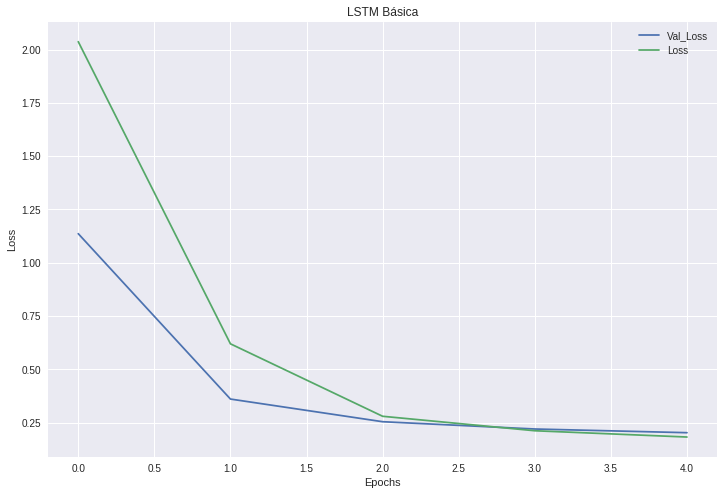

In [55]:
plt.figure(1,figsize=(12,8))
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.legend(('Val_Loss', 'Loss' ))
plt.title('LSTM Básica')
plt.ylabel('Loss')
plt.xlabel('Epochs')

Para evaluar su modelo utilice una métrica adecauda para el desbalance presente entre las clases como identificó en el punto b).

In [72]:
y_pred1=model.predict_classes(X_test,verbose=1)

14425/14425 [==============================] - 14s 985us/step


In [0]:
y_pred=np.argmax(y_pred1,axis=1)

In [77]:
f1_score(y_test_class, y_pred, average="weighted")

0.9771923743500867

In [75]:
f1_score(y_test_class, y_pred, average="macro")

0.9751688297574418

In [76]:
f1_score(y_test_class, y_pred, average="micro")

0.9771923743500867

Aca como mencionamos al principio ponemos en practica los tres posibles metricas de error, encontrando que el valor principal entre ellos es el mismo, de alguna u otra forma por la estructura de la red y el uso de los TAG que estamos viendo hace posible tener un score tan alto. Esperabamos tambien una difernecia mas grande entre ellos pero su diferencia es minimo teniendo en cuenta que el set de datos no tiene una distribución clara y constante.

g) Varı́e la dimensionalidad del embedding inicial y determine si **aumenta o disminuye el error de clasificación**. Comente.

In [78]:
embedding_vector = 64
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=30))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
history1=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 64)            1295552   
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 100)           66000     
_________________________________________________________________
dense_3 (Dense)              (None, 30, 41)            4141      
Total params: 1,365,693
Trainable params: 1,365,693
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 26s 778us/step - loss: 1.6522 - val_loss: 0.5941
Epoch 2/3
33656/33656 [==============================] - 25s 747us/step - loss: 0.3608 - val_loss: 0.2685
Epoch 3/3
33656/33656 [==============================] - 25s 749us/step - loss: 0.2215 - val_loss: 0.2187


En este ejemplo vamos a hacer una apuesta arriesgada colocando 20 epochs, para ver si efectivamente es necesario aumentar eso para tener mejor rendimiento. 

Text(0.5,0,'Epochs')

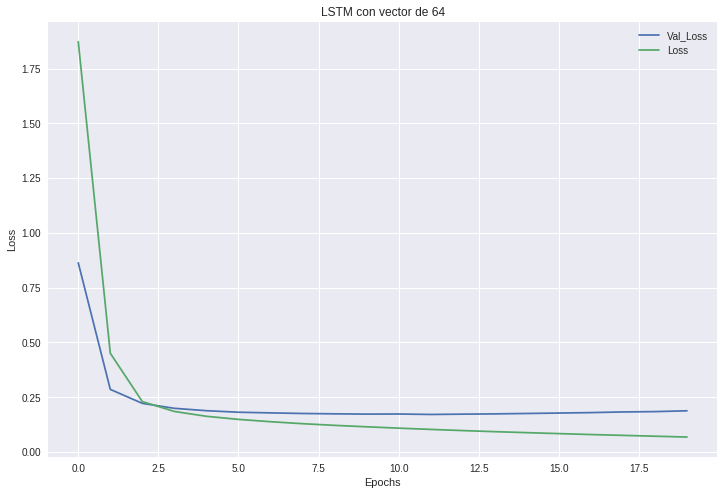

In [0]:
plt.figure(1,figsize=(12,8))
plt.plot(history1.history['val_loss'])
plt.plot(history1.history['loss'])
plt.legend(('Val_Loss', 'Loss' ))
plt.title('LSTM con vector de 64')
plt.ylabel('Loss')
plt.xlabel('Epochs')

In [80]:
model.save('Modelo2.h5')
y_pred1=model.predict_classes(X_test,verbose=1)
y_pred=np.argmax(y_pred1,axis=1)
f1_score(y_test_class, y_pred, average="weighted")

14425/14425 [==============================] - 14s 956us/step


0.9733614157263468

In [81]:
f1_score(y_test_class, y_pred, average="macro")

0.964008896358326

In [82]:
f1_score(y_test_class, y_pred, average="micro")

0.9733102253032929

En este caso nos vamos acercando a un Score de 0.9 mejorando lo que obtuvimos en el primer modelo. En el siguiente modelo vamos a aumentar el numero de embeding para poder determinar si tenemos, igual, mejor o peor rendimiento que en los modelos que obtenemos hasta el momento

In [0]:
embedding_vector = 128
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=30))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
history2=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 30, 128)           2591104   
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 100)           91600     
_________________________________________________________________
dense_4 (Dense)              (None, 30, 41)            4141      
Total params: 2,686,845
Trainable params: 2,686,845
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/5
33656/33656 [==============================] - 56s 2ms/step - loss: 1.6188 - val_loss: 0.5028
Epoch 2/5
33656/33656 [==============================] - 54s 2ms/step - loss: 0.3047 - val_loss: 0.2389
Epoch 3/5
33656/33656 [==============================] - 54s 2ms/step - loss: 0.1961 - val_loss: 0.2010
Epoch 4/5
33656/33656 [===========

Text(0.5,0,'Epochs')

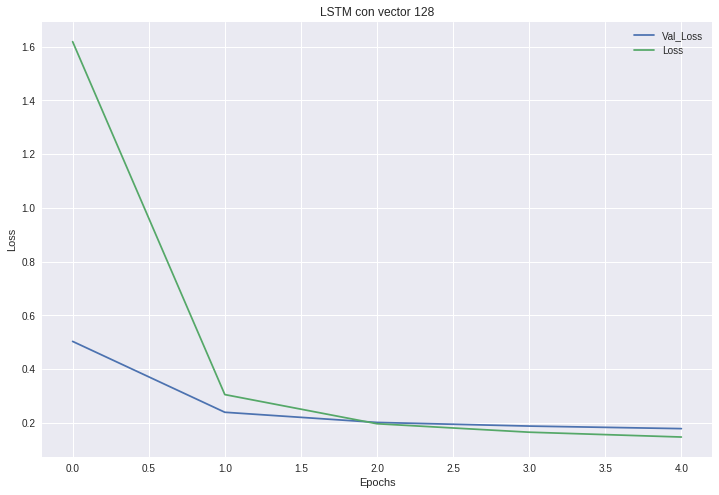

In [0]:
plt.figure(1,figsize=(12,8))
plt.plot(history2.history['val_loss'])
plt.plot(history2.history['loss'])
plt.legend(('Val_Loss', 'Loss' ))
plt.title('LSTM con vector 128')
plt.ylabel('Loss')
plt.xlabel('Epochs')

In [0]:
model.save('Modelo3.h5')
y_pred1=model.predict_classes(X_test,verbose=1)
y_pred=np.argmax(y_pred1,axis=1)
f1_score(y_test_class, y_pred, average="micro")

14425/14425 [==============================] - 7s 519us/step


0.8546273830155979

En este caso aunque tenemos un score menor que el modelo anterior, si analizamos unicamente hasta el epoch 5 del segundo modelo entrenado aca se obtiene un mejor resultado.

In [0]:
embedding_vector = 16
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=30))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
history3=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 30, 16)            323888    
_________________________________________________________________
lstm_5 (LSTM)                (None, 30, 100)           46800     
_________________________________________________________________
dense_5 (Dense)              (None, 30, 41)            4141      
Total params: 374,829
Trainable params: 374,829
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/5
33656/33656 [==============================] - 35s 1ms/step - loss: 2.2229 - val_loss: 1.6953
Epoch 2/5
33656/33656 [==============================] - 33s 993us/step - loss: 1.0587 - val_loss: 0.6088
Epoch 3/5
33656/33656 [==============================] - 33s 994us/step - loss: 0.4160 - val_loss: 0.3242
Epoch 4/5
33656/33656 [===========

Text(0.5,0,'Epochs')

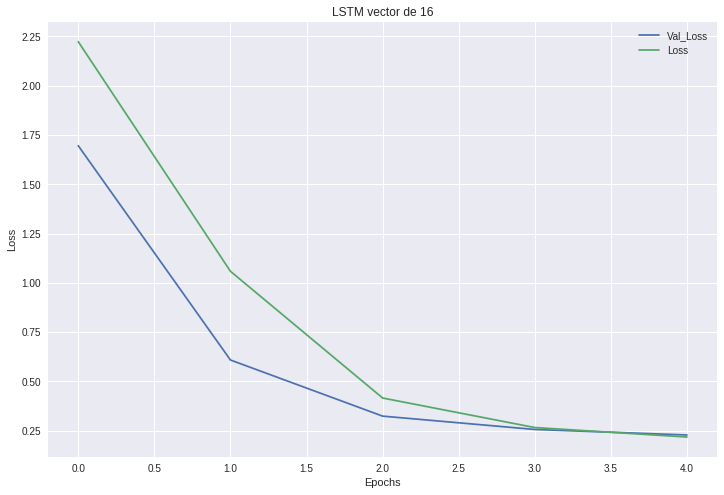

In [0]:
plt.figure(1,figsize=(12,8))
plt.plot(history3.history['val_loss'])
plt.plot(history3.history['loss'])
plt.legend(('Val_Loss', 'Loss' ))
plt.title('LSTM vector de 16')
plt.ylabel('Loss')
plt.xlabel('Epochs')

In [0]:
model.save('Modelo4.h5')
y_pred1=model.predict_classes(X_test,verbose=1)
y_pred=np.argmax(y_pred1,axis=1)
f1_score(y_test_class, y_pred, average="micro")

14425/14425 [==============================] - 6s 387us/step


0.826412478336222

La conclusion de este inciso es bastante clara, tenemos una relación directa entre el numero de embeddings y la función de perdida junto con el F1_Score, teniendo el mayor numero de embeddings se determina que tiene mejor resultado casi en un 0.3 de impacto en la metrica

h) Use *Dropout* para entrenar la LSTM. **¿El *Dropout* mejora el desempeño de la red?** Señale cuáles podrı́an ser las causas del comportamiento observado.

In [28]:
embedding_vector = 64
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=30))
model.add(LSTM(units=100,return_sequences=True)) #or recurrent_dropout=0.2
model.add(Dropout(0.2))
model.add(Dense(n_labels, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.compile(loss='categorical_crossentropy', optimizer='adam')
history4=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)

Train on 33656 samples, validate on 14425 samples
Epoch 1/5
33656/33656 [==============================] - 33s 974us/step - loss: 1.8982 - val_loss: 0.8689
Epoch 2/5
33656/33656 [==============================] - 30s 904us/step - loss: 0.4698 - val_loss: 0.2911
Epoch 3/5
33656/33656 [==============================] - 31s 921us/step - loss: 0.2477 - val_loss: 0.2276
Epoch 4/5
33656/33656 [==============================] - 31s 932us/step - loss: 0.2017 - val_loss: 0.2057
Epoch 5/5
33656/33656 [==============================] - 31s 908us/step - loss: 0.1786 - val_loss: 0.1938


Text(0.5,0,'Epochs')

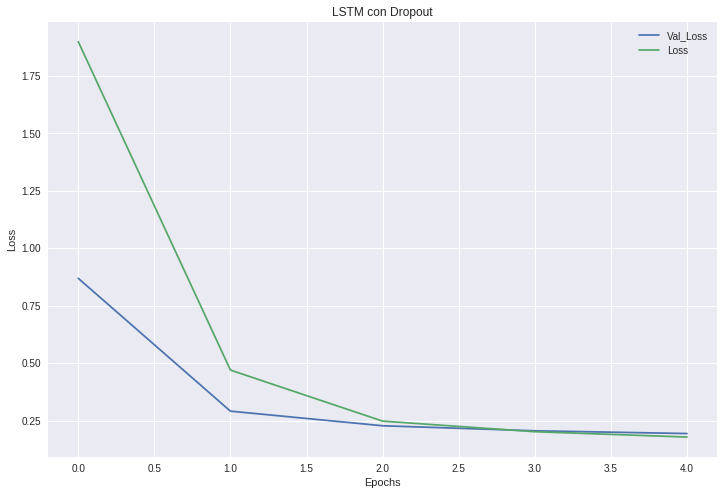

In [29]:
plt.figure(1,figsize=(12,8))
plt.plot(history4.history['val_loss'])
plt.plot(history4.history['loss'])
plt.legend(('Val_Loss', 'Loss' ))
plt.title('LSTM con Dropout')
plt.ylabel('Loss')
plt.xlabel('Epochs')

In [30]:
model.save('Modelo5.h5')
y_pred1=model.predict_classes(X_test,verbose=1)
y_pred=np.argmax(y_pred1,axis=1)
f1_score(y_test_class, y_pred, average="micro")

14425/14425 [==============================] - 17s 1ms/step


0.8922703639514732

Train on 33656 samples, validate on 14425 samples
Epoch 1/5
33656/33656 [==============================] - 32s 961us/step - loss: 1.9082 - val_loss: 0.8415
Epoch 2/5
33656/33656 [==============================] - 31s 913us/step - loss: 0.4654 - val_loss: 0.2841
Epoch 3/5
33656/33656 [==============================] - 31s 922us/step - loss: 0.2510 - val_loss: 0.2242
Epoch 4/5
33656/33656 [==============================] - 31s 933us/step - loss: 0.2061 - val_loss: 0.2039
Epoch 5/5
14425/14425 [==============================] - 18s 1ms/step


0.8917850953206238

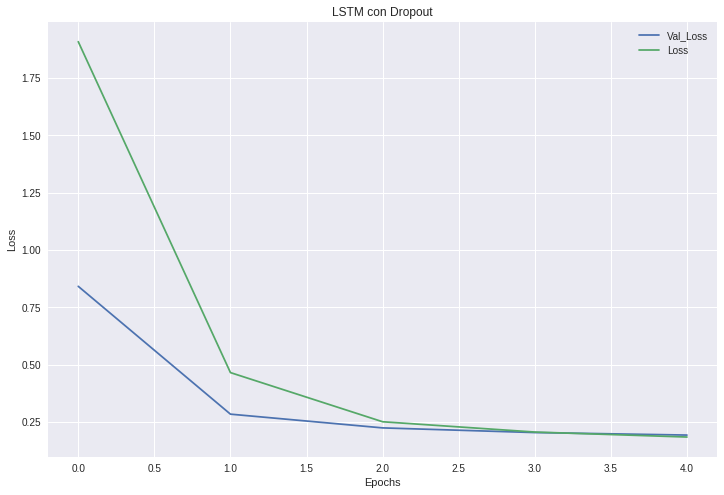

In [31]:
embedding_vector = 64
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=30))
model.add(LSTM(units=100,return_sequences=True)) #or recurrent_dropout=0.2
model.add(Dropout(0.3))
model.add(Dense(n_labels, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.compile(loss='categorical_crossentropy', optimizer='adam')
history4=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)
plt.figure(1,figsize=(12,8))
plt.plot(history4.history['val_loss'])
plt.plot(history4.history['loss'])
plt.legend(('Val_Loss', 'Loss' ))
plt.title('LSTM con Dropout')
plt.ylabel('Loss')
plt.xlabel('Epochs')
model.save('Modelo5dro.h5')
y_pred1=model.predict_classes(X_test,verbose=1)
y_pred=np.argmax(y_pred1,axis=1)
f1_score(y_test_class, y_pred, average="micro")

Train on 33656 samples, validate on 14425 samples
Epoch 1/5
33656/33656 [==============================] - 33s 973us/step - loss: 1.9638 - val_loss: 0.9619
Epoch 2/5
33656/33656 [==============================] - 31s 925us/step - loss: 0.5263 - val_loss: 0.2987
Epoch 3/5
33656/33656 [==============================] - 31s 932us/step - loss: 0.2685 - val_loss: 0.2298
Epoch 4/5
33656/33656 [==============================] - 31s 921us/step - loss: 0.2167 - val_loss: 0.2059
Epoch 5/5
14425/14425 [==============================] - 18s 1ms/step


0.8867937608318891

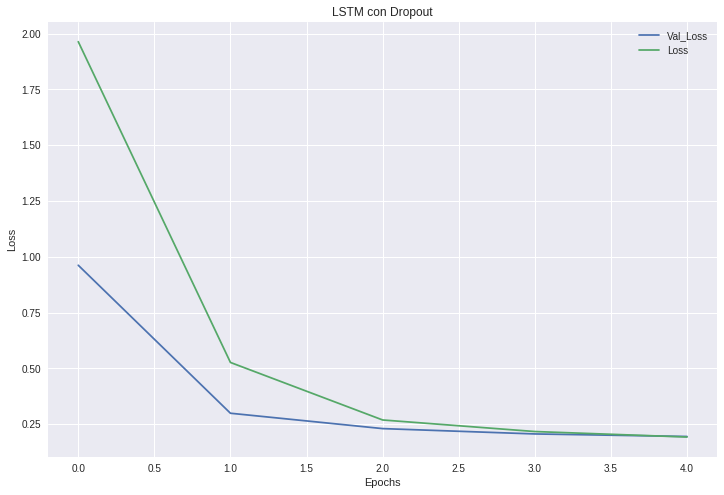

In [32]:
embedding_vector = 64
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=30))
model.add(LSTM(units=100,return_sequences=True)) #or recurrent_dropout=0.2
model.add(Dropout(0.4))
model.add(Dense(n_labels, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.compile(loss='categorical_crossentropy', optimizer='adam')
history4=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)
plt.figure(1,figsize=(12,8))
plt.plot(history4.history['val_loss'])
plt.plot(history4.history['loss'])
plt.legend(('Val_Loss', 'Loss' ))
plt.title('LSTM con Dropout')
plt.ylabel('Loss')
plt.xlabel('Epochs')
model.save('Modelo5dro.h5')
y_pred1=model.predict_classes(X_test,verbose=1)
y_pred=np.argmax(y_pred1,axis=1)
f1_score(y_test_class, y_pred, average="micro")

Si añadimos Dropout al modelo no se tiene un buen resultado de Score, comparado relativamente con los modelos que hemos obtenido hasta el momento, tambien podria ser conveniente evaluar si es necesario elevar ese porcentaje y poder determinar si esta tecnica efectivamente nos puede entregar un mejor resultado.

i) Algunos autores señalan la importante dependencia que existe en texto, no solo con las palabras anteriores, sino que con las que siguen.**Mejore la red definida en f) utilizando una red neuronal recurrente Bidireccional**, es decir, con recurrencia en ambas direcciones sobre la secuencia de *lemmas* de entrada. Comente **cuál debiera ser la forma correcta de usar el parámetro *merge_mode*** (concatenar, multiplicar, sumar o promediar) para este caso. Además comente las transformaciones que sufre el patrón de entrada al pasar por las capas. **¿Mejora o empeora el desempeño?** Analice.

In [33]:
embedding_vector = 64
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=30))
layer_lstm = LSTM(units=100,return_sequences=True)
model.add(Bidirectional(layer_lstm,merge_mode='concat'))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.compile(loss='categorical_crossentropy', optimizer='adam')
history5=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 30, 64)            1295552   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 30, 200)           132000    
_________________________________________________________________
dense_9 (Dense)              (None, 30, 41)            8241      
Total params: 1,435,793
Trainable params: 1,435,793
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/5
33656/33656 [==============================] - 64s 2ms/step - loss: 1.7000 - val_loss: 0.6059
Epoch 2/5
33656/33656 [==============================] - 62s 2ms/step - loss: 0.3139 - val_loss: 0.2109
Epoch 3/5
33656/33656 [==============================] - 62s 2ms/step - loss: 0.1692 - val_loss: 0.1665
Epoch 4/5
33656/33656 [===========

In [34]:
model.save('Modelo6.h5')
y_pred1=model.predict_classes(X_test,verbose=1)
y_pred=np.argmax(y_pred1,axis=1)
f1_score(y_test_class, y_pred, average="micro")

14425/14425 [==============================] - 35s 2ms/step


0.9342807625649914

In [35]:
embedding_vector = 64
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=30))
layer_lstm = LSTM(units=100,return_sequences=True)
model.add(Bidirectional(layer_lstm,merge_mode='sum'))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.compile(loss='categorical_crossentropy', optimizer='adam')
history6=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 30, 64)            1295552   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 30, 100)           132000    
_________________________________________________________________
dense_10 (Dense)             (None, 30, 41)            4141      
Total params: 1,431,693
Trainable params: 1,431,693
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/5
33656/33656 [==============================] - 65s 2ms/step - loss: 1.5797 - val_loss: 0.5061
Epoch 2/5
33656/33656 [==============================] - 62s 2ms/step - loss: 0.2880 - val_loss: 0.2074
Epoch 3/5
33656/33656 [==============================] - 62s 2ms/step - loss: 0.1657 - val_loss: 0.1641
Epoch 4/5
33656/33656 [===========

In [36]:
model.save('Modelo7.h5')
y_pred1=model.predict_classes(X_test,verbose=1)
y_pred=np.argmax(y_pred1,axis=1)
f1_score(y_test_class, y_pred, average="micro")

14425/14425 [==============================] - 35s 2ms/step


0.9331715771230502

In [37]:
embedding_vector = 64
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=30))
layer_lstm = LSTM(units=100,return_sequences=True)
model.add(Bidirectional(layer_lstm,merge_mode='mul'))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.compile(loss='categorical_crossentropy', optimizer='adam')
history7=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 30, 64)            1295552   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 30, 100)           132000    
_________________________________________________________________
dense_11 (Dense)             (None, 30, 41)            4141      
Total params: 1,431,693
Trainable params: 1,431,693
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/5
33656/33656 [==============================] - 65s 2ms/step - loss: 1.8319 - val_loss: 0.6980
Epoch 2/5
33656/33656 [==============================] - 62s 2ms/step - loss: 0.3848 - val_loss: 0.2601
Epoch 3/5
33656/33656 [==============================] - 62s 2ms/step - loss: 0.2046 - val_loss: 0.1978
Epoch 4/5
33656/33656 [===========

In [38]:
model.save('Modelo8.h5')
y_pred1=model.predict_classes(X_test,verbose=1)
y_pred=np.argmax(y_pred1,axis=1)
f1_score(y_test_class, y_pred, average="micro")

14425/14425 [==============================] - 35s 2ms/step


0.922842287694974

In [39]:
embedding_vector = 64
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=30))
layer_lstm = LSTM(units=100,return_sequences=True)
model.add(Bidirectional(layer_lstm,merge_mode='ave'))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.compile(loss='categorical_crossentropy', optimizer='adam')
history8=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 30, 64)            1295552   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 30, 100)           132000    
_________________________________________________________________
dense_12 (Dense)             (None, 30, 41)            4141      
Total params: 1,431,693
Trainable params: 1,431,693
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/5
33656/33656 [==============================] - 65s 2ms/step - loss: 1.9215 - val_loss: 1.0526
Epoch 2/5
33656/33656 [==============================] - 62s 2ms/step - loss: 0.5286 - val_loss: 0.2888
Epoch 3/5
33656/33656 [==============================] - 63s 2ms/step - loss: 0.2178 - val_loss: 0.1945
Epoch 4/5
33656/33656 [===========

In [40]:
model.save('Modelo9.h5')
y_pred1=model.predict_classes(X_test,verbose=1)
y_pred=np.argmax(y_pred1,axis=1)
f1_score(y_test_class, y_pred, average="micro")

14425/14425 [==============================] - 36s 2ms/step


0.9299826689774696

Text(0.5,0,'Epochs')

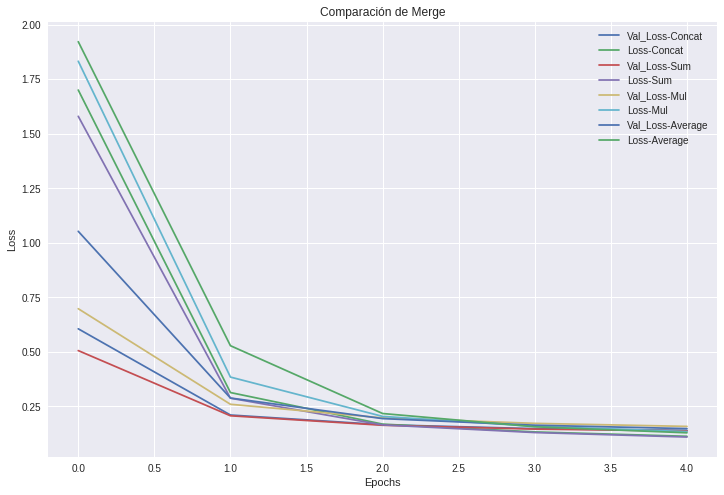

In [41]:
plt.figure(1,figsize=(12,8))
plt.plot(history5.history['val_loss'])
plt.plot(history5.history['loss'])
plt.plot(history6.history['val_loss'])
plt.plot(history6.history['loss'])
plt.plot(history7.history['val_loss'])
plt.plot(history7.history['loss'])
plt.plot(history8.history['val_loss'])
plt.plot(history8.history['loss'])
plt.legend(('Val_Loss-Concat', 'Loss-Concat','Val_Loss-Sum', 'Loss-Sum','Val_Loss-Mul', 'Loss-Mul','Val_Loss-Average', 'Loss-Average' ))
plt.title('Comparación de Merge')
plt.ylabel('Loss')
plt.xlabel('Epochs')

En este caso el mejor rendimiento lo da el modelo que utiliza el parametro SUM es el que tomaremos en los siguientes puntos para hacer mejoras y ver como se comporta el rendimiento. Tiene mucha razón que ambos sum y concatenacia sean los parametros con mejor resultado adeamas es muy importante poder determinar que se debe seguir evaluando los modelos con los diferntes hiperparametros

j) Recientemente se ha implementado la capa de *Masking* en las redes recurrentes en *keras*, lo cual podría traer gran ayuda gracias al *padding* que se realiza con el símbolo especial definido. **Entrene la red definida en f) y compare al utilizar esta funcionalidad de enmascarar el valor 0 en este caso para el *default* de la capa *embedding***, comente sobre las curvas de entrenamiento y los tiempos de entrenamiento.

In [42]:
lemma2idx["yourspecialcharacter"] = 0 #should be zero.. if not correct it
embedding_vector = 64
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=30,mask_zero=True))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
history9=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 30, 64)            1295552   
_________________________________________________________________
lstm_11 (LSTM)               (None, 30, 100)           66000     
_________________________________________________________________
dense_13 (Dense)             (None, 30, 41)            4141      
Total params: 1,365,693
Trainable params: 1,365,693
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/5
33656/33656 [==============================] - 44s 1ms/step - loss: 1.8568 - val_loss: 0.7847
Epoch 2/5
33656/33656 [==============================] - 41s 1ms/step - loss: 0.4075 - val_loss: 0.2751
Epoch 3/5
33656/33656 [==============================] - 40s 1ms/step - loss: 0.2240 - val_loss: 0.2204
Epoch 4/5
33656/33656 [===========

In [43]:
model.save('Modelo10.h5')
y_pred1=model.predict_classes(X_test,verbose=1)
y_pred=np.argmax(y_pred1,axis=1)
f1_score(y_test_class, y_pred, average="micro")

14425/14425 [==============================] - 22s 2ms/step


0.8947660311958405

Text(0.5,0,'Epochs')

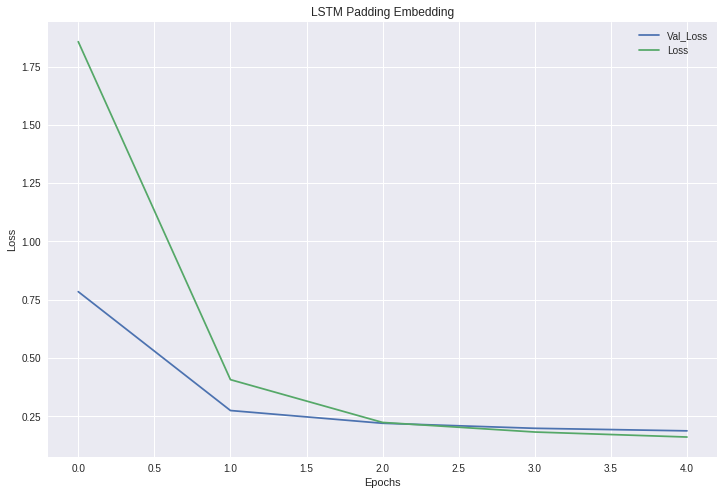

In [44]:
plt.figure(1,figsize=(12,8))
plt.plot(history9.history['val_loss'])
plt.plot(history9.history['loss'])
plt.legend(('Val_Loss', 'Loss' ))
plt.title('LSTM Padding Embedding')
plt.ylabel('Loss')
plt.xlabel('Epochs')

Estos cambios no nos ofrecen mejoras significativas y/o representativas en los resultados que hemos obtenido hasta el momento manteniendo la media y la desviación estandar del performance de los resultados. Esto que tambien puede ser llamado fine tunning es de gran ayuda, desde la parte disciplinar de mi equipo de trabajo donde no habiamos tenido oportunidad de trabajar con estos algoritmos, y verificar lo que dicen lo s articulos con la teoria en si misma dicha,.

k) En base a lo experimentado, **intente mejorar el desempeño de las redes encontradas**, ya sea utilizando y combinando las distintas variaciones que se hicieron en los distintos ítemes, como bien alguna mejora en el pre-proceso de los datos (largo de secuencia, el tipo de *padding* o alguna otra), agregar mayor profundidad, variar el número de unidades/neuronas, utilizando otra *gate* de recurrencia (GRU o Vanilla/Simple), en https://keras.io/layers/recurrent/,  entre otras.

Lo primero que vamos a hacer es determinar con que modelos queremos mejorar el rendimiento, para irlo comparando con lo obtenido anteriormente, vamos a partir evaluando los scores y la convergencia de la función de costo, con esos vamos a tomar los mejores 3 modelos y vamos a hacerles variaciones diferentes a cada uno, para al final poder determinar que variaciones tuvieron mas impacto y cual es nuestro modelo con mejor rendimiento encontrado, ademas como ya modificamos anteriormente vamos a dejar en 20 las epochs para cada prueba.

In [45]:
##Modelo 1 para optimizar con Embedding de 128
##Aumentando neuronas 
embedding_vector = 64
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=30))
model.add(LSTM(units=300,return_sequences=True))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
history101=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 30, 64)            1295552   
_________________________________________________________________
lstm_12 (LSTM)               (None, 30, 300)           438000    
_________________________________________________________________
dense_14 (Dense)             (None, 30, 41)            12341     
Total params: 1,745,893
Trainable params: 1,745,893
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/5
33656/33656 [==============================] - 35s 1ms/step - loss: 1.6128 - val_loss: 0.5715
Epoch 2/5
33656/33656 [==============================] - 32s 957us/step - loss: 0.3288 - val_loss: 0.2471
Epoch 3/5
33656/33656 [==============================] - 32s 942us/step - loss: 0.2014 - val_loss: 0.2051
Epoch 4/5
33656/33656 [=======

In [50]:
model.save('Modelo11.h5')
y_pred1=model.predict_classes(X_test,verbose=1)
y_pred=np.argmax(y_pred1,axis=1)
f1_score(y_test_class, y_pred, average="micro")

14425/14425 [==============================] - 17s 1ms/step


0.8883188908145581

In [46]:
##Aumentando neuronas
embedding_vector = 64
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=30))
model.add(LSTM(units=500,return_sequences=True))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
history102=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 30, 64)            1295552   
_________________________________________________________________
lstm_13 (LSTM)               (None, 30, 500)           1130000   
_________________________________________________________________
dense_15 (Dense)             (None, 30, 41)            20541     
Total params: 2,446,093
Trainable params: 2,446,093
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/5
33656/33656 [==============================] - 37s 1ms/step - loss: 1.4547 - val_loss: 0.4587
Epoch 2/5
33656/33656 [==============================] - 33s 982us/step - loss: 0.2946 - val_loss: 0.2378
Epoch 3/5
33656/33656 [==============================] - 33s 983us/step - loss: 0.1980 - val_loss: 0.2041
Epoch 4/5
33656/33656 [=======

In [49]:
model.save('Modelo12.h5')
y_pred1=model.predict_classes(X_test,verbose=1)
y_pred=np.argmax(y_pred1,axis=1)
f1_score(y_test_class, y_pred, average="micro")

14425/14425 [==============================] - 18s 1ms/step


0.8883188908145581

In [47]:
##Disminuimos neuronas
embedding_vector = 64
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=30))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
history103=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 30, 64)            1295552   
_________________________________________________________________
lstm_14 (LSTM)               (None, 30, 50)            23000     
_________________________________________________________________
dense_16 (Dense)             (None, 30, 41)            2091      
Total params: 1,320,643
Trainable params: 1,320,643
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/5
33656/33656 [==============================] - 35s 1ms/step - loss: 2.0365 - val_loss: 1.1040
Epoch 2/5
33656/33656 [==============================] - 31s 935us/step - loss: 0.5834 - val_loss: 0.3461
Epoch 3/5
33656/33656 [==============================] - 31s 930us/step - loss: 0.2716 - val_loss: 0.2507
Epoch 4/5
33656/33656 [=======

Cuando empezamos a añadir unidades en la ultima capa, de a poco pero el rendimiento va mejorando, esto se ve confirmado en el ultimo caso donde disminuimos radicalmente el numero de neuronas y la precisión baja 2 puntos.

In [48]:
model.save('Modelo13.h5')
y_pred1=model.predict_classes(X_test,verbose=1)
y_pred=np.argmax(y_pred1,axis=1)
f1_score(y_test_class, y_pred, average="micro")

14425/14425 [==============================] - 19s 1ms/step


0.8883188908145581

En el modelo 1 vamos modificar el numero de neuronas en ambas direcciones ya que nosotros para obtenerlo utilizamos mayor numero de embedding. Para los tres modelos vamos a hacer 3 variaciones.

Text(0.5,0,'Epochs')

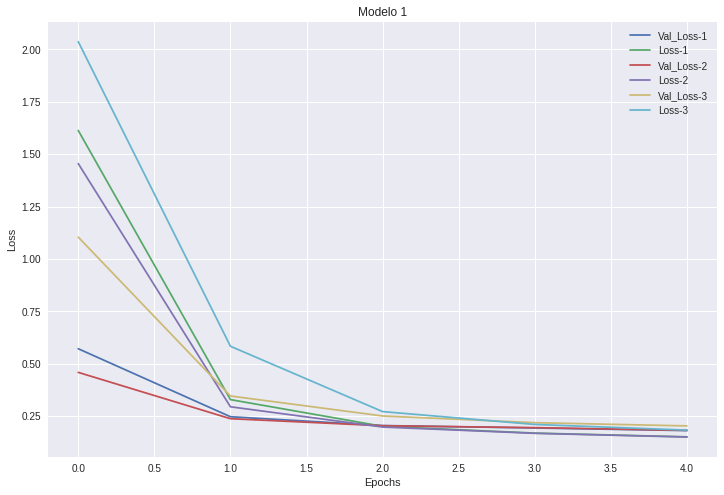

In [51]:
plt.figure(1,figsize=(12,8))
plt.plot(history101.history['val_loss'])
plt.plot(history101.history['loss'])
plt.plot(history102.history['val_loss'])
plt.plot(history102.history['loss'])
plt.plot(history103.history['val_loss'])
plt.plot(history103.history['loss'])
plt.legend(('Val_Loss-1', 'Loss-1','Val_Loss-2', 'Loss-2','Val_Loss-3', 'Loss-3' ))
plt.title('Modelo 1')
plt.ylabel('Loss')
plt.xlabel('Epochs')

Este modelo esta muy facil de analizar, aunque es pequeña pero vemos que al aumentar el numero de neuronas vamos mejorando en el resultado y la diferencia se nota mas con el modelo en el que disminuimos el numero de unidades, esto se debe que al tener mayor numero de unidades libres para entrenar podemos tener mejor representaciones de la información,

Para este modelo vamos a hacer dos variaciones en conjunta, la primera es que vamos a aumentar el numero de embeding en la entrada, y vamos a hacer una variacion en el dropout aumentandolo hasta 50 que es el limite teorico, esto para poder comprobar si efectivamente el 20% es el valor adecuado para nuestro caso.

In [52]:
##Modelo 2 para optimizar utilizando Dropout 
##Aumentamos Dropout a 30
embedding_vector = 64
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=30))
model.add(LSTM(units=100,return_sequences=True)) #or recurrent_dropout=0.2
model.add(Dropout(0.3))
model.add(Dense(n_labels, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.compile(loss='categorical_crossentropy', optimizer='adam')
history111=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)

Train on 33656 samples, validate on 14425 samples
Epoch 1/5
33656/33656 [==============================] - 36s 1ms/step - loss: 1.8835 - val_loss: 0.8369
Epoch 2/5
33656/33656 [==============================] - 32s 938us/step - loss: 0.4830 - val_loss: 0.2931
Epoch 3/5
33656/33656 [==============================] - 31s 930us/step - loss: 0.2569 - val_loss: 0.2277
Epoch 4/5
33656/33656 [==============================] - 32s 938us/step - loss: 0.2096 - val_loss: 0.2068
Epoch 5/5
33656/33656 [==============================] - 32s 943us/step - loss: 0.1871 - val_loss: 0.1941


In [53]:
model.save('Modelo14.h5')
y_pred1=model.predict_classes(X_test,verbose=1)
y_pred=np.argmax(y_pred1,axis=1)
f1_score(y_test_class, y_pred, average="micro")

14425/14425 [==============================] - 19s 1ms/step


0.8894280762564991

In [54]:
##Aumentamos Dropout a 40
embedding_vector = 64
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=30))
model.add(LSTM(units=100,return_sequences=True)) #or recurrent_dropout=0.2
model.add(Dropout(0.4))
model.add(Dense(n_labels, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.compile(loss='categorical_crossentropy', optimizer='adam')
history112=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)

Train on 33656 samples, validate on 14425 samples
Epoch 1/5
33656/33656 [==============================] - 35s 1ms/step - loss: 1.9421 - val_loss: 0.9155
Epoch 2/5
33656/33656 [==============================] - 32s 946us/step - loss: 0.5243 - val_loss: 0.2998
Epoch 3/5
33656/33656 [==============================] - 32s 947us/step - loss: 0.2701 - val_loss: 0.2313
Epoch 4/5
33656/33656 [==============================] - 32s 941us/step - loss: 0.2169 - val_loss: 0.2082
Epoch 5/5
33656/33656 [==============================] - 32s 964us/step - loss: 0.1927 - val_loss: 0.1953


In [0]:
model.save('Modelo15.h5')
y_pred1=model.predict_classes(X_test,verbose=1)
y_pred=np.argmax(y_pred1,axis=1)
f1_score(y_test_class, y_pred, average="micro")

14425/14425 [==============================] - 9s 618us/step


0.8503986135181976

In [55]:
##Aumentamos Dropout a 50
embedding_vector = 64
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=30))
model.add(LSTM(units=100,return_sequences=True)) #or recurrent_dropout=0.2
model.add(Dropout(0.5))
model.add(Dense(n_labels, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.compile(loss='categorical_crossentropy', optimizer='adam')
history113=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)
model.summary()

Train on 33656 samples, validate on 14425 samples
Epoch 1/5
33656/33656 [==============================] - 36s 1ms/step - loss: 1.9467 - val_loss: 0.9018
Epoch 2/5
33656/33656 [==============================] - 31s 919us/step - loss: 0.5306 - val_loss: 0.2993
Epoch 3/5
33656/33656 [==============================] - 31s 924us/step - loss: 0.2756 - val_loss: 0.2323
Epoch 4/5
33656/33656 [==============================] - 31s 931us/step - loss: 0.2246 - val_loss: 0.2088
Epoch 5/5
33656/33656 [==============================] - 31s 933us/step - loss: 0.1997 - val_loss: 0.1969
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 30, 64)            1295552   
_________________________________________________________________
lstm_17 (LSTM)               (None, 30, 100)           66000     
_________________________________________________________________
dropout_10 (Dropout)      

In [56]:
model.save('Modelo16.h5')
y_pred1=model.predict_classes(X_test,verbose=1)
y_pred=np.argmax(y_pred1,axis=1)
f1_score(y_test_class, y_pred, average="micro")

14425/14425 [==============================] - 19s 1ms/step


0.8822876949740035

Text(0.5,0,'Epochs')

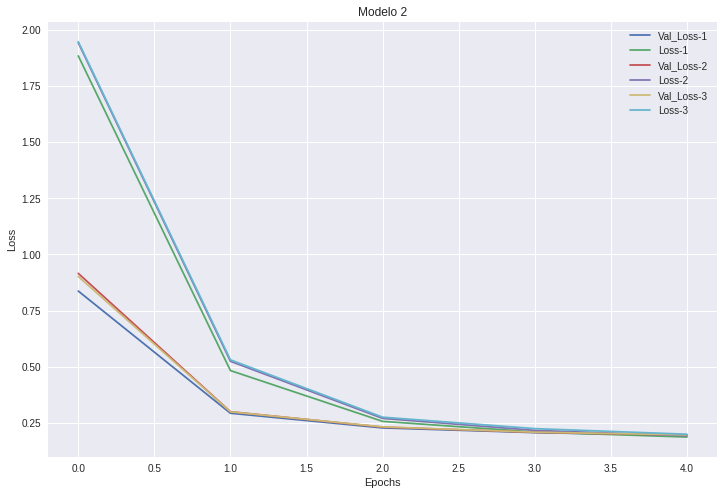

In [57]:
plt.figure(1,figsize=(12,8))
plt.plot(history111.history['val_loss'])
plt.plot(history111.history['loss'])
plt.plot(history112.history['val_loss'])
plt.plot(history112.history['loss'])
plt.plot(history113.history['val_loss'])
plt.plot(history113.history['loss'])
plt.legend(('Val_Loss-1', 'Loss-1','Val_Loss-2', 'Loss-2','Val_Loss-3', 'Loss-3' ))
plt.title('Modelo 2')
plt.ylabel('Loss')
plt.xlabel('Epochs')

Comparando el comportamiento del Dropout desde 20% hasta 50% vemos que no hay una diferencia notable, pero si como se indicaba en el ejercicio el mejor resultado es con el parametro de 0.2 Sin embargo comparandolo con el primer modelo no logra superarlo.

In [58]:
## Modelo 3 Red Recurrente Bidireccional utilizando Sum
## Añadimos una capa
embedding_vector = 64
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=30))
layer_lstm = LSTM(units=100,return_sequences=True)
model.add(Bidirectional(layer_lstm,merge_mode='sum'))
model.add(Dropout(0.2))
model.add(Dense(n_labels, activation='softmax'))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.compile(loss='categorical_crossentropy', optimizer='adam')
history121=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 30, 64)            1295552   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 30, 100)           132000    
_________________________________________________________________
dropout_11 (Dropout)         (None, 30, 100)           0         
_________________________________________________________________
dense_20 (Dense)             (None, 30, 41)            4141      
_________________________________________________________________
dense_21 (Dense)             (None, 30, 41)            1722      
Total params: 1,433,415
Trainable params: 1,433,415
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/5
33656/33656 [==============================] - 68s 2ms/step - loss: 3.27

In [66]:
model.save('Modelo17.h5')
y_pred1=model.predict_classes(X_test,verbose=1)
y_pred=np.argmax(y_pred1,axis=1)
f1_score(y_test_class, y_pred, average="micro")

14425/14425 [==============================] - 20s 1ms/step


0.8993414211438475

In [60]:
## Añadimos dos capas
embedding_vector = 64
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=30))
layer_lstm = LSTM(units=100,return_sequences=True)
model.add(Bidirectional(layer_lstm,merge_mode='sum'))
model.add(Dropout(0.2))
model.add(Dense(n_labels, activation='softmax'))
model.add(Dense(n_labels, activation='softmax'))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.compile(loss='categorical_crossentropy', optimizer='adam')
history122=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 30, 64)            1295552   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 30, 100)           132000    
_________________________________________________________________
dropout_12 (Dropout)         (None, 30, 100)           0         
_________________________________________________________________
dense_22 (Dense)             (None, 30, 41)            4141      
_________________________________________________________________
dense_23 (Dense)             (None, 30, 41)            1722      
_________________________________________________________________
dense_24 (Dense)             (None, 30, 41)            1722      
Total params: 1,435,137
Trainable params: 1,435,137
Non-trainable params: 0
_________________________________________________________________


In [62]:
model.save('Modelo18.h5')
y_pred1=model.predict_classes(X_test,verbose=1)
y_pred=np.argmax(y_pred1,axis=1)
f1_score(y_test_class, y_pred, average="micro")

14425/14425 [==============================] - 37s 3ms/step


0.07812824956672444

In [61]:
## Añadimos tres capas
embedding_vector = 64
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=30))
layer_lstm = LSTM(units=100,return_sequences=True)
model.add(Bidirectional(layer_lstm,merge_mode='sum'))
model.add(Dropout(0.2))
model.add(Dense(n_labels, activation='softmax'))
model.add(Dense(n_labels, activation='softmax'))
model.add(Dense(n_labels, activation='softmax'))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.compile(loss='categorical_crossentropy', optimizer='adam')
history123=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 30, 64)            1295552   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 30, 100)           132000    
_________________________________________________________________
dropout_13 (Dropout)         (None, 30, 100)           0         
_________________________________________________________________
dense_25 (Dense)             (None, 30, 41)            4141      
_________________________________________________________________
dense_26 (Dense)             (None, 30, 41)            1722      
_________________________________________________________________
dense_27 (Dense)             (None, 30, 41)            1722      
_________________________________________________________________
dense_28 (Dense)             (None, 30, 41)            1722      
Total para

In [63]:
model.save('Modelo19.h5')
y_pred1=model.predict_classes(X_test,verbose=1)
y_pred=np.argmax(y_pred1,axis=1)
f1_score(y_test_class, y_pred, average="micro")

14425/14425 [==============================] - 35s 2ms/step


0.07812824956672444

En este modelo vamos a añadir mas profundidad a la red, ademas de añadir un Dropout de 20 en la primera capa y con un embedding de 64, casi que seria un resumen de los mejores modelos pero modificando la profundidad para poder observar si efectivamente al tener mas capas podemos representar mejor las caracteristicas del modelo


Text(0.5,0,'Epochs')

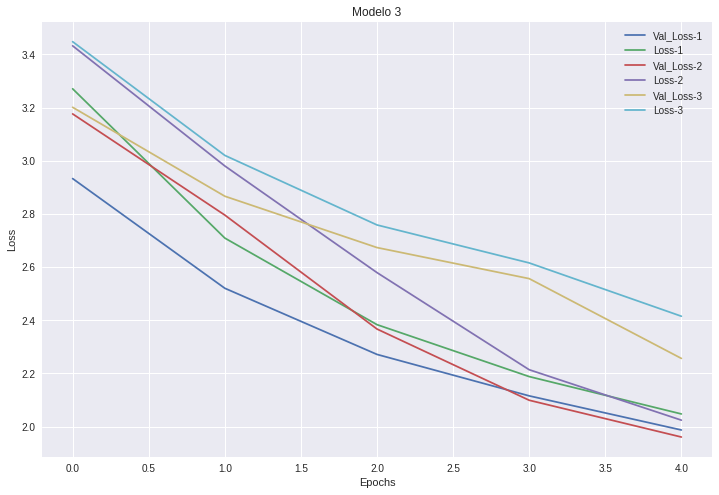

In [64]:
plt.figure(1,figsize=(12,8))
plt.plot(history121.history['val_loss'])
plt.plot(history121.history['loss'])
plt.plot(history122.history['val_loss'])
plt.plot(history122.history['loss'])
plt.plot(history123.history['val_loss'])
plt.plot(history123.history['loss'])
plt.legend(('Val_Loss-1', 'Loss-1','Val_Loss-2', 'Loss-2','Val_Loss-3', 'Loss-3' ))
plt.title('Modelo 3')
plt.ylabel('Loss')
plt.xlabel('Epochs')

Analizando las graficas tienen un comportamiento muy interesante, obviamente tiene el peor rendimiento visto no solo en los modelos a optimizar, si no en todos los demas, esto nos indica que en este tipo de aplicación es necesario un modelo Shallow que un Deep, por que teoricamente con el conjunto de modificaciónes que se utilizaron deberiamos si fuera optimo un módelo Deep, ptero comprobamos todo lo contrario.

<b>El mejor modelo encontrado es aumentando el numero de neuronas, con 64 Embeddings, es el modelo que vamos a evaluar en los siguientes items</b>

l) Utilice la red entranda anteriormente, **se espera que sea la mejor de esta sección**, y **muestre las predicciones**, el *NER tager*, sobre algún ejemplo de pruebas, comente. 

In [16]:
embedding_vector = 64
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=30))
layer_lstm = LSTM(units=100,return_sequences=True)
model.add(Bidirectional(layer_lstm,merge_mode='sum'))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.compile(loss='categorical_crossentropy', optimizer='adam')
historyend=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)
    ##MEJOR MODELO ENCONTRADO

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 64)            1295552   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 30, 100)           132000    
_________________________________________________________________
dense_1 (Dense)              (None, 30, 41)            4141      
Total params: 1,431,693
Trainable params: 1,431,693
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/5
33656/33656 [==============================] - 61s 2ms/step - loss: 1.5800 - val_loss: 0.4849
Epoch 2/5
33656/33656 [==============================] - 59s 2ms/step - loss: 0.2766 - val_loss: 0.2020
Epoch 3/5
33656/33656 [==============================] - 59s 2ms/step - loss: 0.1603 - val_loss: 0.1611
Epoch 4/5
33656/33656 [===========

In [17]:
model.save('BestModeloend.h5')
y_pred1=model.predict_classes(X_test,verbose=1)
y_pred=np.argmax(y_pred1,axis=1)
f1_score(y_test_class, y_pred, average="micro")

14425/14425 [==============================] - 34s 2ms/step


0.9357365684575389

In [19]:
X_test[1].shape

(30,)

In [20]:
i=5
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
print("{:15}: {}".format("Lemma", "Pred"))
lemmas=list(lemmas)
labels=list(labels)
for w,pred in zip(X_test[i],p[0]):
    print("{:15}: {}".format(lemmas[w],labels[pred]))

Lemma          : Pred
some           : DT
rebel          : NNS
have           : VBP
refus          : VBN
to             : TO
sign           : VB
the            : DT
accord         : NN
.              : .
0              : .
0              : .
0              : .
0              : .
0              : .
0              : .
0              : .
0              : .
0              : .
0              : .
0              : .
0              : .
0              : .
0              : .
0              : .
0              : .
0              : .
0              : .
0              : .
0              : .
0              : .


En la primera parte vemos que esta trabajando corretamente la maquina, ya que tiene la producción de los textos aunque no de la forma como se hace con los compañeros que trabajaron con las 17 muesras.

m) **Carge las palabras del dataset** ¿Por qué no los *lemmas*? y cree el corpus con el cual se trabajará, además de crear la codificación de caracteres a números. Esto se presenta en el código a continuación además de crear la estrucutura de los datos con los que se va a trabajar (sub sentencias del corpus original). **Utilice el tamaño del *corpus* que le acomode a la memoria de su computador**.

In [21]:
dataset = df_ner.loc[:,["word","lemma"]]
text = ' '.join(dataset["word"]).lower() #corpus
null_character = "*"
chars = [null_character]+sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = {c: i for i, c in enumerate(chars)}
indices_char = {i: c for i, c in enumerate(chars)}
maxlen = 40 # cut the text in semi-redundant sequences of maxlen characters
step = 5 
sentences = []
next_chars = []
size = int(len(text)*0.8) #solo un 20% del corpus
for i in range(0, size - maxlen, step):
    sentences.append(null_character+text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

total chars: 72
nb sequences: 970794


n) **Procese las sentencias para así tenerlas codificadas en números que van a representar los carácteres**, tal cual se realizó en c) con los *lemmas*, **lo mismo para las etiquetas**. Además de esto deberá realizar el *padding* correspondiente al comienzo de la sentencia, esto es para que la red aprenda cuando venga una frase mas corta de lo entrenado, este símbolo siignificará que no hay información. **Transforme las etiquetas a *one hot vector*** como se realizó en c) y **defina la red** similar a la presentada en f), con un *embedding* seguido de una capa recurrente GRU y la capa de clasificación. Aprovechese de la implementación más rápida de GRU respaldada por __[CuDNN](https://developer.nvidia.com/cudnn)__, una librería de CUDA (NVIDIA)[[2]](#refs) para *Deep Neural Network*. 

In [24]:
dataX = [[char_indices[char] for char in sentence ] for sentence in sentences]
dataY = [char_indices[char] for char in next_chars]
char_indices["0"] = 0
indices_char["0"] = 0

print("Numero de caracteres: ", len(char_indices))
print("Indices: ", len(indices_char))
print("Matrix Y: ", len(dataY))
print("Matriz X: ", len(dataX))

Numero de caracteres:  72
Indices:  73
Matrix Y:  970794
Matriz X:  970794


In [0]:
x = sequence.pad_sequences(dataX, maxlen=30, padding='post',value = char_indices["0"])
y = np.asarray([to_categorical(i, num_classes = len(chars)) for i in dataY])

In [45]:
x.shape

(970794, 30)

In [50]:
y.shape

(970794, 72)

In [26]:
from keras.layers import CuDNNGRU,GRU
embedding_vector = 16
model = Sequential()
model.add(Embedding(input_dim=len(chars), output_dim=embedding_vector, input_length=30))#
model.add(CuDNNGRU(units=512,return_sequences=False)) #or GRU
model.add(Dropout(0.2))
model.add(Dense(len(chars), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 16)            1152      
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 512)               814080    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 72)                36936     
Total params: 852,168
Trainable params: 852,168
Non-trainable params: 0
_________________________________________________________________


o) Entrene la red con las funciones que se presentan a continuación que mostrarán el cómo va la tarea de autocompletar texto en cada *epoch*, generando una sentencia completa de 400 carácteres *aleatoriamente* a partir de una semilla *random*. Entrene solo durante 25 *epochs*, a los 15 ya debería comenzar a generar palabras y sonar mas coherente **¿Cuál es la técnica para predecir el siguiente carácter?**

In [0]:
def predict_next_char(model, sentence):
    """Predict the next character from the current one"""    
    x_pred = [char_indices[null_character]]+[char_indices[char] for char in sentence]
    x_pred = sequence.pad_sequences([x_pred], maxlen=30,padding='pre',value=char_indices[null_character])
    preds = model.predict(x_pred, verbose=0)[0]
    next_index = np.random.choice(len(chars), p=preds) #take a sample
    return indices_char[next_index]

import random,sys
def on_epoch_end(epoch, logs):
    """Function invoked at end of each epoch. Prints generated text."""
    print('\n----- Generating text after Epoch: %d' % epoch)
    start_index = random.randint(0, size - maxlen - 1)
    sentence = text[start_index: start_index + maxlen]
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(sentence)
    for i in range(400):
        next_char = predict_next_char(model, sentence)
        sentence = sentence[1:] + next_char #for next character
        sys.stdout.write(next_char)
        sys.stdout.flush()
    return

In [63]:
from keras.callbacks import LambdaCallback
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
pd.DataFrame(model.fit(x, y,batch_size=512,epochs=25, callbacks=[print_callback]).history).to_csv("history_1O.csv")
model.save("model_1O.h5")

Epoch 1/25
970794/970794 [==============================] - 112s 116us/step - loss: 1.0911 - acc: 0.6710

----- Generating text after Epoch: 0
----- Generating with seed: "in the school after an aborted attempt t"
in the school after an aborted attempt to vote arient in hatpennar from an israeli nest record homes with the month posed in military . mr. nejace omer decisions in the propobies frem . u.n. envoy to share the secters . wounded one after arafting them released and evidence at a creation of the acche of parts of israel . indian prime minister and palestinian president murabuza , had river earlier . the u.s. site of many crieits . an el-cEpoch 2/25
970794/970794 [==============================] - 113s 116us/step - loss: 1.0760 - acc: 0.6750

----- Generating text after Epoch: 1
----- Generating with seed: "n southwest china 's yunnan province . t"
n southwest china 's yunnan province . the air officers part is blamed to a province . megia dependence and police " sacivition powe

p) Verifique la calidad de la red entrenada, cargando el modelo si es que lo guardó o directamente, entregando una predicción sobre una semilla inicial que usted entregue. **Observe y comente cualitativamente sobre qué pasa cuando la predicción del siguiente carácter fuese de manera determinista, tomando el máximo valor de entre las predicciones.**

In [64]:
sentence = "it is "
print('----- Generating with seed: "' + sentence + '"')
sys.stdout.write(sentence)
for i in range(400):
    next_char = predict_next_char(model, sentence)
    sentence = sentence[1:] + next_char 
    sys.stdout.write(next_char)
    sys.stdout.flush()

----- Generating with seed: "it is "
it is flaction . he planes are flooring ethnic has ruled toop last youl sinces in the easing terms of preside . islamical famous and from acture to europens . pparanys of morral obdectoder chargel gapes , with greation , mr. awerdan hards with on are states the commiss to leaders danbers , who wan for as a new facuse that countra moantest will bomb , which trivife intert jassi interated bankile govern t

***Conclusiones***
El procesamiento de lenguaje natural suele ser mucho mas complejo que el procesamiento de señales, imagenes o videos, en este caso nosotros tuvimos muchos problemas en el momento de crear el vector de represetnaciones, tanto como con la dimensión de los datos como  en elegir el tipo de padding correcto, ademas es importante saber que hay un universo de posibles representaciones, que hay ademas palabras que tienen mas o menos imapcto.

Podemos nombrar otros tipos de desafios que encontramos aca y que nos parecen que peuden seguir siendo objeto de estudio, la elección del tipo de padding correcto, su relacion con el backpropagation, la celda de memoria en las redes recurrentes, y en que aplicaciones debe elegirse alguna de las variante.


Un ultimo pero no menos importante item es la metrica con la que se debe evaluar la parte exprimental del desarrollo, nosotros elegimos micro que la aplicamos en todo el desarrollo de la tarea, pero no entendiamos  muy bien el algoritmo y cuando logramos comprender mejor este artilugio matematico se udo comprender que la tener un set de datos bastante dispurso, es necesario contar con la mejor metrica posible para gartantizar un analisis concreto y correcto de la experimentacion hecha